In [1]:
import pandas as pd
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Model #1: Sklearn Neural Network

In [2]:
#Read in the dataframe
comments = pd.read_json('categorized-comments.jsonl', lines = True, nrows = 606475)

#Reduce the size of the dataframe. Our model will learn most with higher sample, but want it to run quickly
comments_small = comments.sample(n=5000)

In [3]:
#Let's make a new column to tokenize and clean our comments
comments_small['Tokens'] = comments_small.txt.astype(str)

#Lowercase everything so we don't have some words appearing twice and occurences being split
comments_small.Tokens = comments_small.Tokens.apply(lambda x: " ".join(x.lower() for x in x.split()))

#Remove all punctuation
comments_small.Tokens = comments_small.Tokens.str.replace('[^\w\s]','')

#Remove our stop words that don't hold much value
stop = stopwords.words('english')
comments_small.Tokens = comments_small.Tokens.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#Stem our words to help combine them
stemmer = PorterStemmer()
comments_small.Tokens = comments_small.Tokens.apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

<ipython-input-3-a78645ab1712>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  comments_small.Tokens = comments_small.Tokens.str.replace('[^\w\s]','')


In [4]:
#Lets find the 3000 most important words across the comments
tfidf = TfidfVectorizer(max_features = 3000)

In [5]:
#We are going to use our tokens column to predict our category column
X = tfidf.fit_transform(comments_small.Tokens)
y = comments_small.cat

In [6]:
#Split it into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=11)

In [7]:
#Import our classifier
from sklearn.neural_network import MLPClassifier

In [8]:
#Get our model settings right
nn_mod1 = MLPClassifier(hidden_layer_sizes = [500,150], verbose = True)

In [9]:
#Now let's use the training data (X_train, y_train) to predict our category.
target_predicted = nn_mod1.fit(X_train, y_train).predict(X_test)

Iteration 1, loss = 0.82078696
Iteration 2, loss = 0.62236762
Iteration 3, loss = 0.44570094
Iteration 4, loss = 0.30256657
Iteration 5, loss = 0.22431673
Iteration 6, loss = 0.17455883
Iteration 7, loss = 0.14169894
Iteration 8, loss = 0.11608851
Iteration 9, loss = 0.09819927
Iteration 10, loss = 0.08991280
Iteration 11, loss = 0.08622183
Iteration 12, loss = 0.08354546
Iteration 13, loss = 0.08206702
Iteration 14, loss = 0.08139388
Iteration 15, loss = 0.08191729
Iteration 16, loss = 0.08004866
Iteration 17, loss = 0.07785579
Iteration 18, loss = 0.07932246
Iteration 19, loss = 0.07854181
Iteration 20, loss = 0.08096869
Iteration 21, loss = 0.07608846
Iteration 22, loss = 0.07807805
Iteration 23, loss = 0.07737410
Iteration 24, loss = 0.07825016
Iteration 25, loss = 0.07681095
Iteration 26, loss = 0.07662739
Iteration 27, loss = 0.07732100
Iteration 28, loss = 0.07729130
Iteration 29, loss = 0.07781927
Iteration 30, loss = 0.07759858
Iteration 31, loss = 0.07828681
Iteration 32, los

In [10]:
#Lets check out what we got
matrix = confusion_matrix(y_test, target_predicted)

In [11]:
#Getting ready to show the confusion matrix
class_names = ['Science and Technology', 'Sports', 'Video Games']
dataframe = pd.DataFrame(matrix, columns=class_names, index=class_names)

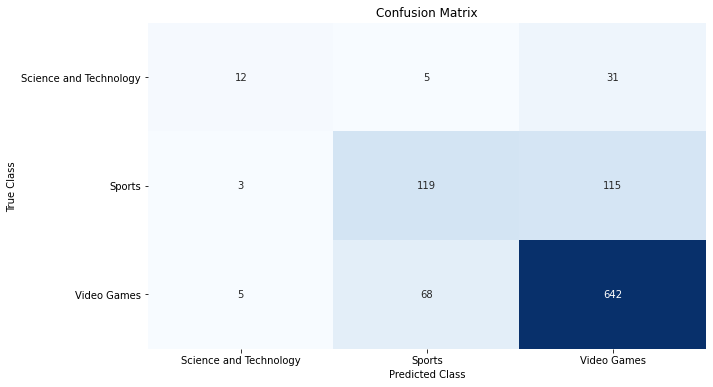

In [12]:
#And we can graph it. Not amazing but not bad
plt.figure(figsize=(10,6))
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [13]:
#We didn't have many science and technology comments in our data, so it was hard to teach the model to catch it. 
#The video games section works out pretty well though. 

print(classification_report(y_test,
                           target_predicted, 
                           target_names=class_names))

                        precision    recall  f1-score   support

Science and Technology       0.60      0.25      0.35        48
                Sports       0.62      0.50      0.55       237
           Video Games       0.81      0.90      0.85       715

              accuracy                           0.77      1000
             macro avg       0.68      0.55      0.59      1000
          weighted avg       0.76      0.77      0.76      1000



# Model 2: Keras Model

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from sklearn.datasets import make_multilabel_classification

In [15]:
#Set up the variables we need, and make multilabel classification

N_FEATURES = 3000
N_CLASSES=3

X, y = make_multilabel_classification(n_samples=5000, n_features=3000, n_classes=3, n_labels=3, random_state=1)
# summarize dataset shape
print(X.shape, y.shape)

(5000, 3000) (5000, 3)


In [16]:
#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=11)

In [17]:
#Make our model
nn=Sequential()
nn.add(Dense(500, activation='relu', input_shape=(N_FEATURES,)))
nn.add(Dense(150, activation='relu'))
nn.add(Dense(N_CLASSES, activation='sigmoid'))
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
#Fit the model to the training data
nn.fit(X_train, y_train, epochs=200, batch_size=128)

Epoch 1/200
32/32 [==============================] - 1s 25ms/step - loss: 0.5382 - accuracy: 0.2438
Epoch 2/200
32/32 [==============================] - 1s 25ms/step - loss: 0.2910 - accuracy: 0.6285
Epoch 3/200
32/32 [==============================] - 1s 24ms/step - loss: 0.0993 - accuracy: 0.6285
Epoch 4/200
32/32 [==============================] - 1s 23ms/step - loss: 0.0188 - accuracy: 0.6380 0s - loss: 0.0191 - accuracy: 0.63
Epoch 5/200
32/32 [==============================] - 1s 23ms/step - loss: 0.0042 - accuracy: 0.6180
Epoch 6/200
32/32 [==============================] - 1s 25ms/step - loss: 0.0019 - accuracy: 0.5993
Epoch 7/200
32/32 [==============================] - 1s 24ms/step - loss: 0.0012 - accuracy: 0.5982
Epoch 8/200
32/32 [==============================] - 1s 27ms/step - loss: 8.3481e-04 - accuracy: 0.5895
Epoch 9/200
32/32 [==============================] - 1s 23ms/step - loss: 6.2727e-04 - accuracy: 0.5980 0s - loss: 6.2727e-04 - accuracy: 0.59
Epoch 10/200
32/32

Epoch 74/200
32/32 [==============================] - 1s 28ms/step - loss: 6.0575e-06 - accuracy: 0.5623
Epoch 75/200
32/32 [==============================] - 1s 23ms/step - loss: 5.8666e-06 - accuracy: 0.5615
Epoch 76/200
32/32 [==============================] - 1s 25ms/step - loss: 5.6834e-06 - accuracy: 0.5623
Epoch 77/200
32/32 [==============================] - 1s 25ms/step - loss: 5.5064e-06 - accuracy: 0.5630
Epoch 78/200
32/32 [==============================] - 1s 25ms/step - loss: 5.3368e-06 - accuracy: 0.5633
Epoch 79/200
32/32 [==============================] - 1s 23ms/step - loss: 5.1748e-06 - accuracy: 0.5633
Epoch 80/200
32/32 [==============================] - 1s 24ms/step - loss: 5.0196e-06 - accuracy: 0.5627 0s - loss: 4.9528e-06 - accura
Epoch 81/200
32/32 [==============================] - 1s 26ms/step - loss: 4.8693e-06 - accuracy: 0.5625
Epoch 82/200
32/32 [==============================] - 1s 22ms/step - loss: 4.7248e-06 - accuracy: 0.5623
Epoch 83/200
32/32 [====

In [19]:
#Make predictions on the test data
predictions = nn.predict(X_test)

In [20]:
#Round the numbers so we can compare
predictions = predictions.round()

In [21]:
#Print the classification report. It has been giving me errors here, may need to start up the next section after 
#Running this
print(classification_report(y_test,
                           predictions, 
                           target_names=class_names))

                        precision    recall  f1-score   support

Science and Technology       0.86      0.94      0.90       787
                Sports       0.86      0.97      0.91       824
           Video Games       0.57      0.44      0.50       344

             micro avg       0.82      0.86      0.84      1955
             macro avg       0.76      0.78      0.77      1955
          weighted avg       0.81      0.86      0.83      1955
           samples avg       0.82      0.81      0.79      1955



C:\Users\David\anaconda3\envs\Testing\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\David\anaconda3\envs\Testing\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model #3: Images

In [22]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

In [23]:
K.set_image_data_format('channels_last')

In [24]:
np.random.seed(0)

In [25]:
channels=1
height=28
width=28

In [26]:
(data_train, target_train), (data_test, target_test) = mnist.load_data()

In [27]:
data_train = data_train.reshape(data_train.shape[0], height, width, channels)

In [28]:
data_test = data_test.reshape(data_test.shape[0], height, width, channels)

In [29]:
features_train = data_train / 255
features_test = data_test / 255

In [30]:
features_test.shape

(10000, 28, 28, 1)

In [31]:
target_train = np_utils.to_categorical(target_train)
target_test = np_utils.to_categorical(target_test)
number_of_classes = target_test.shape[1]

In [32]:
target_test.shape

(10000, 10)

In [33]:
#Build the neural network
network = Sequential()

#Add a convolutional layer with 64 filters, a 5x5 window and a ReLU activation function
network.add(Conv2D(filters=64,
                 kernel_size=(5,5),
                 input_shape=(width, height, channels),
                 activation='relu'))

#Add a max pooling layer with 2x2 window
network.add(MaxPooling2D(pool_size=(2,2)))

#Add a dropout layer
network.add(Dropout(0.5))

#Add a layer to flatten input
network.add(Flatten())

#Add a fully connected layer with 128 units and ReLU activation function
network.add(Dense(128, activation='relu'))

#Add a dropout layer
network.add(Dropout(0.5))

#add a fully connected layer with softmax activation function
network.add(Dense(number_of_classes, activation='softmax'))

#compile the model
network.compile(loss='categorical_crossentropy',
               optimizer='rmsprop',
               metrics=['accuracy'])



In [34]:
#Train the neural network
network.fit(features_train,
           target_train,
           epochs=2,
           verbose=1,
           batch_size=1000)

Epoch 1/2
60/60 [==============================] - 64s 1s/step - loss: 0.5833 - accuracy: 0.8202
Epoch 2/2
60/60 [==============================] - 62s 1s/step - loss: 0.1893 - accuracy: 0.9444


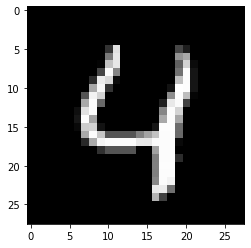

In [35]:
#Let's try to predict this image. We should get 4

plt.imshow(features_test[4], cmap=plt.get_cmap('gray'))

In [36]:
#Lets get the image in the right dimensions for our model
img = features_test[4]
img.shape

(28, 28, 1)

In [37]:
#Setting the dimensions to be right. It should be number of images, height, width, channels
img = np.expand_dims(img,0)
img.shape

(1, 28, 28, 1)

In [38]:
#Let's predict the number. All of them should be small except for the 5th (0,1,2,3 all before 4) which is close to 1
network.predict(img)

array([[1.5135172e-05, 2.6792259e-05, 8.0592734e-05, 7.7359609e-06,
        9.9648958e-01, 1.2645596e-05, 2.0100904e-04, 1.5404330e-04,
        7.2383475e-05, 2.9400436e-03]], dtype=float32)

array([[1, 1, 1],
       [1, 0, 0],
       [1, 1, 1],
       ...,
       [1, 1, 0],
       [1, 1, 0],
       [1, 1, 1]])